In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, get_scheduler
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch
from IPython.display import  clear_output
import time
import gc
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-3B-Instruct"

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )


model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    use_safetensors=True,
    device_map=device,
)

print(model.get_memory_footprint()/(1024*1024)) 

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2095.841064453125


# Load a Multi Lingual Dataset

In [2]:
from datasets import load_dataset

# Load the dataset
# dataset = load_dataset("OdiaGenAI/hardcode_odia_qa_105")
dataset = load_dataset('OdiaGenAI/odia_domain_context_train_v1')

In [3]:
dataset['train'][50]

{'instruction': 'ଓଡ଼ିଶାର ଉଦୟଗିରି ଏବଂ ଖଣ୍ଡଗିରି ଗୁମ୍ଫାର ଇତିହାସ କ’ଣ?',
 'input': '',
 'output': 'ଉଦୟଗିରି ଏବଂ ଖଣ୍ଡଗିରି ଗୁମ୍ଫା ଭାରତର ଓଡ଼ିଶା ରାଜ୍ୟରେ ଅବସ୍ଥିତ ପ୍ରାଚୀନ ଗୁମ୍ଫା ପରିସରର ଏକ ସମୂହ। ଏହି ଗୁମ୍ଫା ଗୁଡିକ ଖ୍ରୀଷ୍ଟପୂର୍ବ ଦ୍ୱିତୀୟ ଶତାବ୍ଦୀ ଏବଂ ପ୍ରଥମ ଶତାବ୍ଦୀ ମଧ୍ୟରେ ଜୈନ ସନ୍ନ୍ୟାସୀମାନଙ୍କ ଦ୍ୱାରା ବାଲୁକା ପଥରରେ ଖୋଦିତ ହୋଇଥିବା ଜଣାଯାଏ।\nଉଦୟଗିରି ଗୁମ୍ଫା ଗୁଡିକ ବୃହତ ଏବଂ ଅଧିକ ଜଟିଳ ହୋଇଥିବାବେଳେ ଖଣ୍ଡଗିରି ଗୁମ୍ଫା ଗୁଡିକ ଛୋଟ ଏବଂ ଡିଜାଇନ ଦୃଷ୍ଟିରୁ ସରଳ। ଏହି ପ୍ରାଚୀନ ଗୁମ୍ଫା ଗୁଡିକ ପ୍ରାଚୀନ ଭାରତୀୟ ସଭ୍ୟତାର ସ୍ଥାପତ୍ୟ କୌଶଳ ଏବଂ କଳାତ୍ମକ ଶ୍ରେଷ୍ଠତାର ପ୍ରମାଣ।\nବିଗତ ବର୍ଷମାନଙ୍କରେ ଏହି ଗୁମ୍ଫା ସାରା ବିଶ୍ୱରୁ ପର୍ଯ୍ୟଟକଙ୍କ ଆକର୍ଷଣ କେନ୍ଦ୍ର ପାଲଟିଛି ଏବଂ ଭାରତୀୟ ପ୍ରତ୍ନତାତ୍ୱିକ ସର୍ବେକ୍ଷଣ ଦ୍ୱାରା ସଂରକ୍ଷିତ ହୋଇଛି। ଭାରତର ସମୃଦ୍ଧ ସାଂସ୍କୃତିକ ଐତିହ୍ୟ ପ୍ରତି ଆଗ୍ରହୀ ଯେକୌଣସି ବ୍ୟକ୍ତି ଏହି ଗୁମ୍ଫାକୁ ଦେଖିବା ଉଚିତ।'}

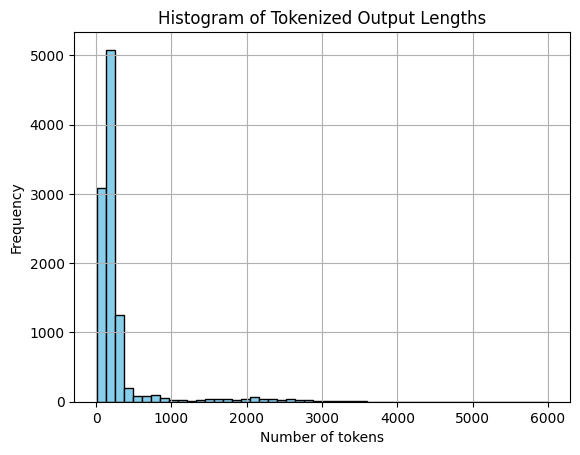

In [5]:
import matplotlib.pyplot as plt
lengths = [len(tokenizer(example['output'])['input_ids']) for example in dataset['train']]

# Plot the histogram
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Tokenized Output Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Create the Dataset Object for Pytorch-Dataset

In [ ]:
# Custom PyTorch Dataset
class LlamaDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        question=sample['instruction']
        answer = sample['output']
        prompt = f'''<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\n{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''
        full_text = prompt+f'''{answer}<|eot_id|>'''

        tokenized = tokenizer(full_text, truncation=True, add_special_tokens=False, padding="max_length", max_length=1000)

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Tokenize just the prompt to get the split point
        prompt_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]
        answer_start = len(prompt_ids)

        # Mask everything before answer_start
        labels = [-100] * answer_start + input_ids[answer_start:]
        # Mask out padding as well
        labels = [
            label if token != tokenizer.pad_token_id else -100
            for label, token in zip(labels, input_ids)
        ]
    
        return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attention_mask),
        "labels": torch.tensor(labels)
    }
        

In [5]:
train_dataset = LlamaDataset(dataset['train'])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [8]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

model.embed_tokens.weight  dtype: torch.float16  requirs grad:  True
model.layers.0.self_attn.q_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.k_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.v_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.o_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.gate_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.up_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.down_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.input_layernorm.weight  dtype: torch.float16  requirs grad:  True
model.layers.0.post_attention_layernorm.weight  dtype: torch.float16  requirs grad:  True
model.layers.1.self_attn.q_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.1.self_attn.k_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.1.self_attn.v_proj.weight  dt

# Purpose of `prepare_model_for_kbit_training`

When you load a model in 4-bit or 8-bit precision using bitsandbytes, some layers (like LayerNorm) still remain in full precision (float32), and certain operations (like weight updates) can be unstable or incompatible if done blindly on quantized weights.

- Casts `LayerNorm` layers to `float32`
- Sets `requires_grad=False` for all model parameters
- Wraps the output layer (like `lm_head`) in `float32`

In [9]:
model = prepare_model_for_kbit_training(model)

In [10]:
model.is_gradient_checkpointing

True

In [11]:
model = PeftModel.from_pretrained(model, 'adapter', is_trainable=True)

In [12]:
model.is_gradient_checkpointing

True

In [ ]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

In [ ]:
# config = LoraConfig(
#     r=64,
#     lora_alpha=16,
#     target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
#     task_type="CAUSAL_LM",
#     lora_dropout=0.05,
#     bias="none",
#     inference_mode=False,
#     use_rslora=True,
#     init_lora_weights="gaussian",
# )

# model = get_peft_model(model, config)
model.print_trainable_parameters()

In [ ]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

In [ ]:
# question = '''ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ପାଇଁ ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ର କିପରି ମିଳିମିଶି କାର୍ଯ୍ୟ କରିପାରିବେ?'''
# answer = '''ଯେକୌଣସି ରାଜ୍ୟରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ପାଇଁ ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରର ମିଳିତ ପ୍ରୟାସର ଆବଶ୍ୟକତା ରହିଛି। ଓଡ଼ିଶାର ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ର ରାଜ୍ୟରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଲାଗି ଏକ ବିସ୍ତୃତ ରଣନୀତି ବିକଶିତ ଏବଂ କାର୍ଯ୍ୟକାରୀ କରିବା ଲାଗି ମିଳିତ ଭାବେ କାର୍ଯ୍ୟ କରିପାରିବେ।
# ସରକାର ଘରୋଇ କ୍ଷେତ୍ର ସହିତ ମିଶି କାମ କରିବାର ଗୋଟିଏ ଉପାୟ ହେଲା ଘରୋଇ ନିବେଶ ପାଇଁ ଅନୁକୂଳ ବାତାବରଣ ସୃଷ୍ଟି କରିବା, ଏଥିରେ ଘରୋଇ କ୍ଷେତ୍ରର ଭାଗିଦାରୀକୁ ପ୍ରୋତ୍ସାହିତ କରିବା ପାଇଁ ଟିକସ ଏବଂ ନିୟାମକ ପ୍ରତିବନ୍ଧକକୁ ହ୍ରାସ କରିବା, ଏହା ବ୍ୟତୀତ ସରକାର ଟିକସ ରିହାତି, ସବସିଡି ଏବଂ ପର୍ଯ୍ୟଟନ ବିକାଶ ପ୍ରକଳ୍ପ ପାଇଁ ଜମି ଆଦି ପ୍ରୋତ୍ସାହନ ମଧ୍ୟ ପ୍ରଦାନ କରିପାରିବେ।
# ଘରୋଇ କ୍ଷେତ୍ର ସହ ମିଶି ସରକାର ଘରୋଇ କ୍ଷେତ୍ର ସହ ମିଶି ନୂତନ ପର୍ଯ୍ୟଟନ ଉତ୍ପାଦ ପ୍ରସ୍ତୁତ କରିପାରିବେ ଯାହା ଉଭୟ ଘରୋଇ ଏବଂ ଅନ୍ତର୍ଜାତୀୟ ପର୍ଯ୍ୟଟକଙ୍କ ଆବଶ୍ୟକତା ପୂରଣ କରିପାରିବ।
# ସରକାର ମଧ୍ୟ ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରର ଭାଗିଦାରୀକୁ ପ୍ରୋତ୍ସାହିତ କରିବା ପାଇଁ ପ୍ରଯୁକ୍ତିର ଉପଯୋଗ କରିପାରିବେ। ଉଦାହରଣ ସ୍ୱରୂପ, ସରକାର ପର୍ଯ୍ୟଟନ ସ୍ଥଳକୁ ପ୍ରୋତ୍ସାହିତ କରିବା ଏବଂ ସମ୍ଭାବ୍ୟ ପର୍ଯ୍ୟଟକମାନଙ୍କ ସହିତ ଯୋଡ଼ିବା ଲାଗି ସୋସିଆଲ ମିଡିଆ ପ୍ଲାଟଫର୍ମର ଉପଯୋଗ କରିପାରିବେ। ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନ ଆକର୍ଷଣ ଏବଂ ଅନୁଭବ ପ୍ରଦର୍ଶିତ କରିବା ଲାଗି ଏକ ଅନଲାଇନ ପ୍ଲାଟଫର୍ମ ପ୍ରତିଷ୍ଠା କରିବା ଦ୍ୱାରା ଅଧିକ ପର୍ଯ୍ୟଟକଙ୍କୁ ଆକର୍ଷିତ କରିବାରେ ସହାୟତା ମିଳିପାରିବ।
# ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଲାଗି ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରକୁ ମିଳିତ ଭାବେ କାର୍ଯ୍ୟ କରିବାକୁ ପଡିବ ଯେପରିକି ପର୍ଯ୍ୟଟନ ଗତିବିଧି ଦ୍ୱାରା ପର୍ଯ୍ୟାବରଣର କ୍ଷୟ କିମ୍ବା ସ୍ଥାନୀୟ ସମ୍ପ୍ରଦାୟର କ୍ଷତି ନ ହେଉ।
# ଶେଷରେ, ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରକୁ ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଲାଗି ଏକ ଅନୁକୂଳ ପରିବେଶ ସୃଷ୍ଟି କରିବା ଆବଶ୍ୟକ ଏବଂ ଏହା ସୁନିଶ୍ଚିତ କରିବା ଉଚିତ ଯେ ବିକାଶ ସ୍ଥାୟୀ ହେବ। ” ମିଳିତ ଭାବେ କାର୍ଯ୍ୟ କରି ସେମାନେ ପର୍ଯ୍ୟଟନ ରଣନୀତିକୁ ବିକଶିତ ଏବଂ କାର୍ଯ୍ୟକାରୀ କରିପାରିବେ ଯାହା କେବଳ ପର୍ଯ୍ୟଟନ ଉଦ୍ୟୋଗ ନୁହେଁ ବରଂ ସ୍ଥାନୀୟ ଗୋଷ୍ଠୀ ଏବଂ ପରିବେଶକୁ ମଧ୍ୟ ଲାଭାନ୍ୱିତ କରିବ।'''

# tokenized_text = tokenizer(answer).input_ids
# print(len(tokenized_text))
# for idx in range(len(tokenized_text)):
#     clear_output(wait=True)
#     print(tokenizer.decode(tokenized_text[0:idx]))
#     time.sleep(0.1)

# Finetune the LLAMA model on a single text

In [ ]:
for batch in train_dataloader:
    break

tokenizer.batch_decode(batch['input_ids'])

In [9]:
def generate_eval(model,idx=5,disable_lora=False):
    
    model.config.use_cache = True
    sample=dataset['train'][idx]
    question=sample['instruction']
    answer = sample['output']
    chat_template = f'''<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\n{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''
    inputs = tokenizer(chat_template , return_tensors="pt").to(device)
    # print(prompt)

    model.eval()


    if disable_lora:
        with model.disable_adapter():
            output = model.generate(
                **inputs,
                do_sample=True,
                max_new_tokens=512,
                repetition_penalty=1.3,
                temperature=0.7,         # Optional: smooth randomness
                top_k=50,                # Optional: top-k sampling
                top_p=0.9                # Optional: nucleus sampling
            )
    else:
        output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=512,
        repetition_penalty=1.3,
        temperature=0.7,         # Optional: smooth randomness
        top_k=50,                # Optional: top-k sampling
        top_p=0.9                # Optional: nucleus sampling
        )

    processed_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    model.train()

    return processed_text

In [ ]:
dataset['train'][40]

In [ ]:
pred = generate_eval(model=model,idx=40,disable_lora=False)
print(pred)

In [ ]:
model.config.use_cache = False
model.config.pretraining_tp = 1
gradient_accumulation_steps = 4
max_steps=500
max_loss = 1e9


# Define optimizer
optimizer = PagedAdam32bit(model.parameters(), lr=1e-4)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_steps,
)
# Training loop
model.train()

global_step= 0

while global_step< max_steps:
    for step,batch in enumerate(train_dataloader):
        model.config.use_cache = False
        model.train()
        
        # Forward pass
        outputs = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'), labels=batch['labels'].to('cuda'))
        loss = outputs.loss
        loss = loss / gradient_accumulation_steps  # Normalize loss
        loss.backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        
        global_step += 1
        if global_step >= max_steps:
            break
        
        if global_step % 20 == 0:
            pred = generate_eval(model=model,idx=40,disable_lora=False)
            print('*'*20,step+1,'*'*20)
            print("Predictions:", pred)
            print('*'*20,'end','*'*20)
            
        if loss.item() < max_loss:
            model.save_pretrained('/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')
            max_loss = loss.item()
            
            
            
        
        print(f"Epoch {global_step + 1}/{max_steps}, Loss: {loss.item():.4f}")
        
flush()

# Loading the LoRA and saving the Adapter

In [ ]:
# model_with_adapter.save_pretrained('/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')

In [7]:
# Load the adapter into the base model
model = PeftModel.from_pretrained(model, '/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj):

In [10]:
pred = generate_eval(model,idx=40,disable_lora=False)
print(pred)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|begin_of_text|> <|start_header_id|>user<|end_header_id|>

ଭୁବନେଶ୍ୱରର ରାଜାରାଣୀ ମନ୍ଦିରର ଇତିହାସ କ’ଣ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ପୂର୍ବ-ଗୋଟିଏ ଖୈଳଧଙ୍ଚ, ଯେଉଁଠି ଅଂଘାଡ଼ି ସୃଷ୍ଟି ଥିଲା। ଆଞ୍ଚଳିକ ସୌନ୍ଦର୍ଯ୍ୟ ସଫର କରିଛି, ଓ ସ୍ଥାନୀୟ ଔପନିବେଶକମାନେ ପ୍ରଵେଶ କରୁଛନ୍ତି।
" " - ଢ. ପ୍ରୋଫେସର ଐ. ରେନି (1928) | ଏହା ତ୍ରୟୋଦଶ ଶତାବ୍ଦୀରେ ସମ୍ପର୍କିତ ଏକ ଜାରିବାର ପାଳନ କରୁଛି । ରାଜାରାଣୀ ଦୁ


In [ ]:
# Path to your saved checkpoint
save_path = "/home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt"

# Load checkpoint
checkpoint = torch.load(save_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

# Restore model, optimizer, scheduler, and step
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
global_step = checkpoint['global_step']

# print(f"Checkpoint loaded from {save_path} at step {global_step}")

In [ ]:
checkpoint

In [ ]:
global_step = checkpoint['global_step']

In [ ]:
global_step

: 

In [ ]:
save_path = "/home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'global_step': global_step
}, save_path)

print(f"Checkpoint saved to {save_path}")